In [15]:
import numpy as np
from qiskit import *
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
from POVMMeasure import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from SequentialPOVMMeasurement import SequentialPOVMMeasurement

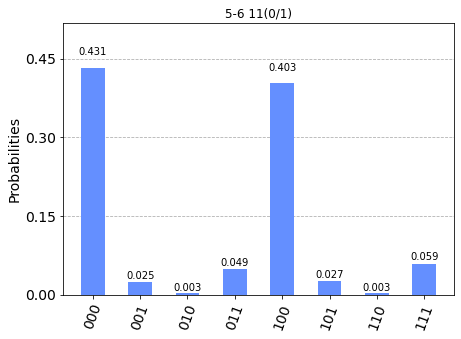

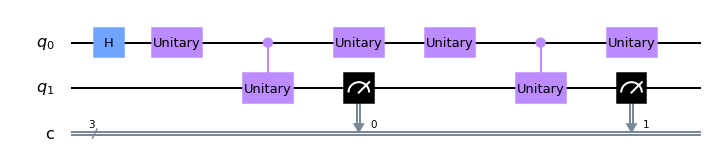

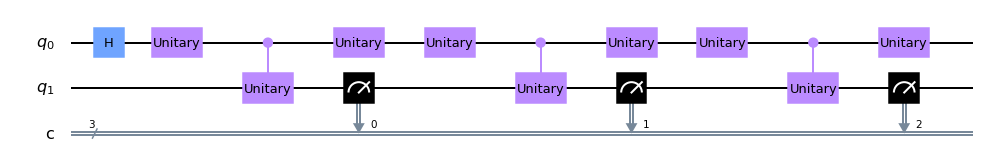

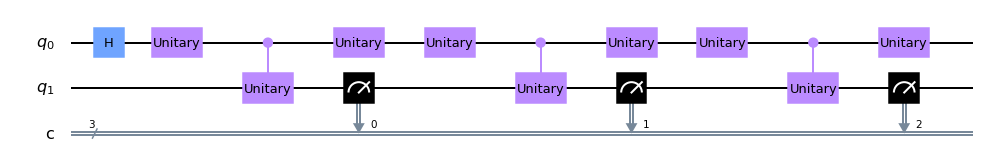

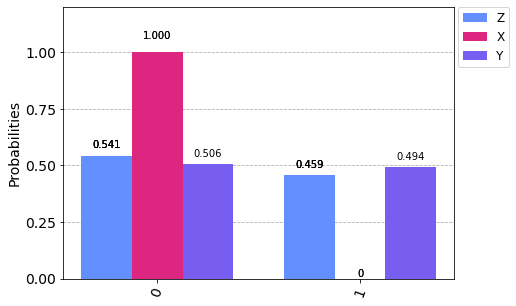

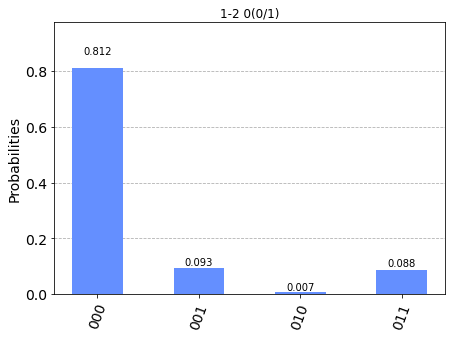

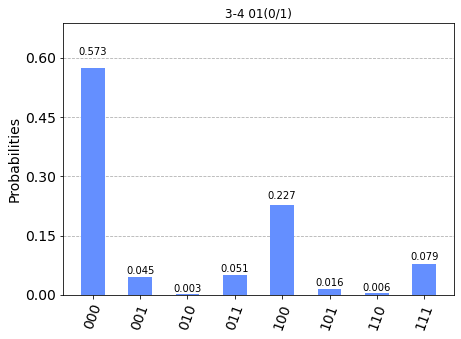

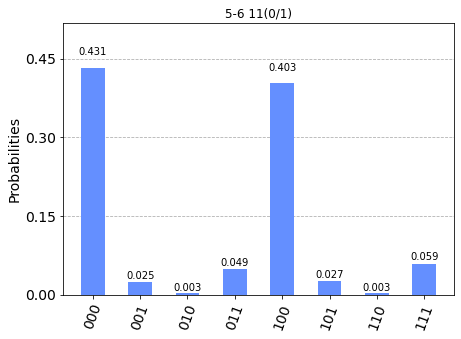

In [16]:

povm_effects = [
    np.array([[1/6, 1/6],
              [1/6, 1/6]]),
    np.array([[1/6, -1/6],
              [-1/6, 1/6]]),
    np.array([[1/6, 0+(-1j/6)],
              [0+(1j/6), 1/6]]),
    np.array([[1/6, 0+(-1j/6)],
              [0+(1j/6), 1/6]]),
    np.array([[1/3, 0],
              [0, 0]]),
    np.array([[0, 0],
              [0, 1/3]])
]

seq = SequentialPOVMMeasurement(povm_effects, [1, 2, 3, 4, 5, 6])
state = QuantumCircuit(1, 1)
state.h(0)
circuits = seq.make_circuits([[1, 2], [[3, 4], [5, 6]]], state)
circuits[0][0].draw('mpl')
circuits[1][0].draw('mpl')
circuits[2][0].draw('mpl')

test_circuit = QuantumCircuit(1,1)
test_circuit.h(0)

z_measure = QuantumCircuit(1,1)
z_measure.measure(0,0)
z_measure = test_circuit + z_measure

y_measure = QuantumCircuit(1,1)
y_measure.sdg(0)
y_measure.h(0)
y_measure.measure(0,0)

y_measure = test_circuit + y_measure

x_measure = QuantumCircuit(1,1)
x_measure.h(0)
x_measure.measure(0,0)

x_measure = test_circuit + x_measure

qasm = qiskit.Aer.get_backend("qasm_simulator")
job_z = qiskit.execute(z_measure, qasm, shots=1000)
job_x = qiskit.execute(x_measure, qasm, shots=1000)
job_y = qiskit.execute(y_measure, qasm, shots=1000)
job_1 = qiskit.execute(circuits[0][0], qasm, shots=1000)
job_2 = qiskit.execute(circuits[1][0], qasm, shots=1000)
job_3 = qiskit.execute(circuits[2][0], qasm, shots=1000)

legend1 = ["Z", "X", "Y"]
plot_histogram([job_z.result().get_counts(), job_x.result().get_counts(), job_y.result().get_counts()], legend=legend1)
plot_histogram(job_1.result().get_counts(), title=circuits[0][1])
plot_histogram(job_2.result().get_counts(), title=circuits[1][1])
plot_histogram(job_3.result().get_counts(), title=circuits[2][1])

